<a href="https://colab.research.google.com/github/aerionator/concrete_crack/blob/main/Test_Concrete_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
arnavr10880_concrete_crack_images_for_classification_path = kagglehub.dataset_download('arnavr10880/concrete-crack-images-for-classification')

print('Data source import complete.')


**Import Library**

In [ ]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


**Directory**

In [ ]:
# Define dataset directory paths
dataset_dir = '/kaggle/input/concrete-crack-images-for-classification'
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=15,  # Augmentation: rotate images
    width_shift_range=0.1,  # Augmentation: shift width
    height_shift_range=0.1,  # Augmentation: shift height
    shear_range=0.2,  # Augmentation: shear transformation
    zoom_range=0.2,  # Augmentation: zoom in/out
    horizontal_flip=True,  # Augmentation: flip horizontally
    validation_split=0.2  # 20% of data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=64,  # Larger batch size for faster training
    class_mode='categorical',  # Two classes: positive and negative
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),  # Resize validation images to 128x128
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)


Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


Build Model

In [ ]:
# Building the CNN model
model = Sequential()
model.add(Input(shape=(128, 128, 3)))  # Input layer for images resized to 128x128 with 3 color channels

# First Convolution + Pooling layer
model.add(Conv2D(16, (3, 3), activation='relu'))  # Fewer filters to reduce computation
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolution + Pooling layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolution + Pooling layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening layer
model.add(Flatten())

# Fully connected Dense layer
model.add(Dense(128, activation='relu'))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.5))  # Dropout rate of 50%

# Output layer with softmax activation for 2 classes
model.add(Dense(2, activation='softmax'))

# Compile the model with Adam optimizer and a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,602 (6.22 MB)

 Trainable params: 1,629,602 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [ ]:
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during training (change to .keras extension)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs as necessary
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]  # Add callbacks to prevent overfitting
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.8679 - loss: 0.3129 - val_accuracy: 0.9906 - val_loss: 0.0450
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 399s 793ms/step - accuracy: 0.9819 - loss: 0.0674 - val_accuracy: 0.9902 - val_loss: 0.0358
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 402s 799ms/step - accuracy: 0.9830 - loss: 0.0620 - val_accuracy: 0.9916 - val_loss: 0.0324
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 398s 791ms/step - accuracy: 0.9851 - loss: 0.0537 - val_accuracy: 0.9881 - val_loss: 0.0461
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 446s 799ms/step - accuracy: 0.9867 - loss: 0.0490 - val_accuracy: 0.9945 - val_loss: 0.0229
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 407s 809ms/step - accuracy: 0.9878 - loss: 0.0419 - val_accuracy: 0.9940 - val_loss: 0.0196
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 415s 824ms/step - accuracy: 0.9879 - loss: 0.0384 - val_accuracy: 0.9941 - val_loss: 0.0204
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 443s 826ms/step - accuracy: 0.9897 - loss: 0.0329 

Visualiation Accuracy and Loss

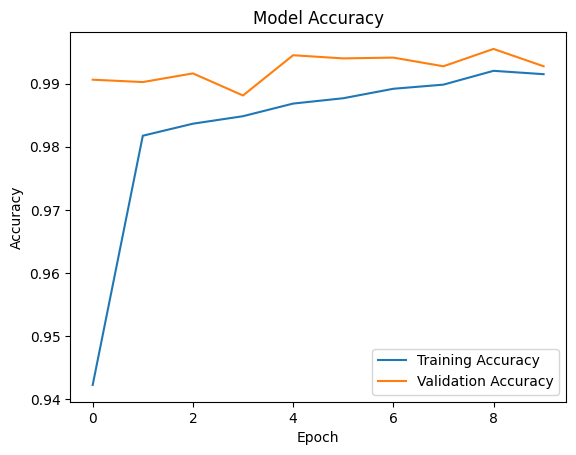

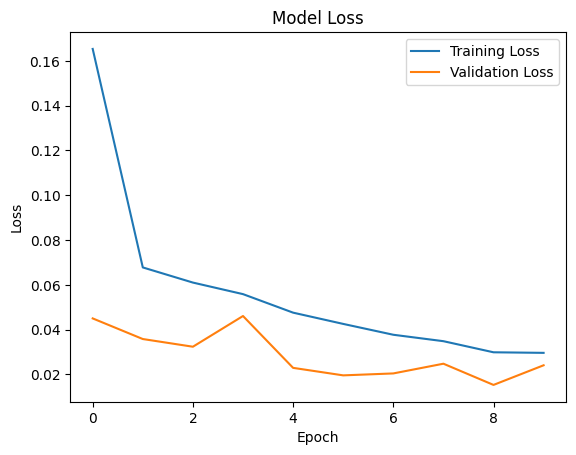

In [ ]:
# Visualize accuracy and loss after training
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 484ms/step - accuracy: 0.9912 - loss: 0.0314
Validation Accuracy: 99.21%
